In [26]:
from data_loader import Data_Loader
import pm4py

num = 1
path = f'/Users/philippeichhorn/Downloads/Compositional process discovery_experiment data/IP-{num}/IP-{num}_initial_log.xes'
list_of_nets = Data_Loader.create_petri_nets(path)


parsing log, completed traces ::   0%|          | 0/5000 [00:00<?, ?it/s]

In [83]:
from pm4py.objects.petri_net.obj import PetriNet
from pm4py.objects.petri_net.utils import petri_utils

def remove_local_transition(net, transition):
    if len(transition.in_arcs) == 1 and len(transition.out_arcs) == 1:
        place_before_transition = list(transition.in_arcs)[0].source  # will be removed
        if len(place_before_transition.in_arcs) == 1 and len(place_before_transition.out_arcs) == 1:
            first_transition = list(place_before_transition.in_arcs)[0].source  # will point to last place
            place_after_transition = list(transition.out_arcs)[0].target #gets pointed from first_transition
            if (len(place_after_transition.in_arcs)== 1):
                petri_utils.add_arc_from_to(first_transition, place_after_transition, net)
                print("added one arc to: ")
                print(transition.label)
                petri_utils.remove_transition(net, transition)
                petri_utils.remove_place(net, place_before_transition)

                return True

    return False
def remove_transition(net, transition):
    #check if current transition has one in on out arc (might not be sufficient todo check)
    # find a t1 
    for other_trans in net.transitions:
        if (other_trans.in_arcs == transition.in_arcs and other_trans.out_arcs == transition.out_arcs and transition != other_trans):
            petri_utils.remove_transition(net, transition)
            return True
    return False


def remove_place(net, place):
    for other_place in net.places:
        if(set(arc.source for arc in other_place.in_arcs) == set(arc.source for arc in place.in_arcs) and set(arc.target for arc in other_place.out_arcs) == set(arc.target for arc in place.out_arcs) and place != other_place):
            petri_utils.remove_place(net, place)
            return True
    return False


def place_merge(net, place):
    for other_place in net.places:
        
        #4th
        if (len((set(arc.source for arc in other_place.in_arcs)).intersection(set(arc.source for arc in place.in_arcs))) == 0):
            #6TH:
            set_of_places_to_t3_1 = set()
            set_of_places_to_t3_2 = set()
            for x in set(arc.target for arc in place.out_arcs):
                set_of_places_to_t3_1 = set_of_places_to_t3_1.union(set(arc.source for arc in x.in_arcs))
            for x in set(arc.target for arc in other_place.out_arcs):
                set_of_places_to_t3_1 = set_of_places_to_t3_1.union(set(arc.source for arc in x.in_arcs))
        
            set_of_places_to_t3_1.discard(place)  # Use discard to safely remove element
            set_of_places_to_t3_2.discard(other_place)  # Use discard to safely remove element
            
            if set_of_places_to_t3_1 == set_of_places_to_t3_2:  # Compare sets directly
                petri_utils.remove_place(net, place)
                return True
            else:
                petri_utils.remove_place(net, place)

                return True
    return False

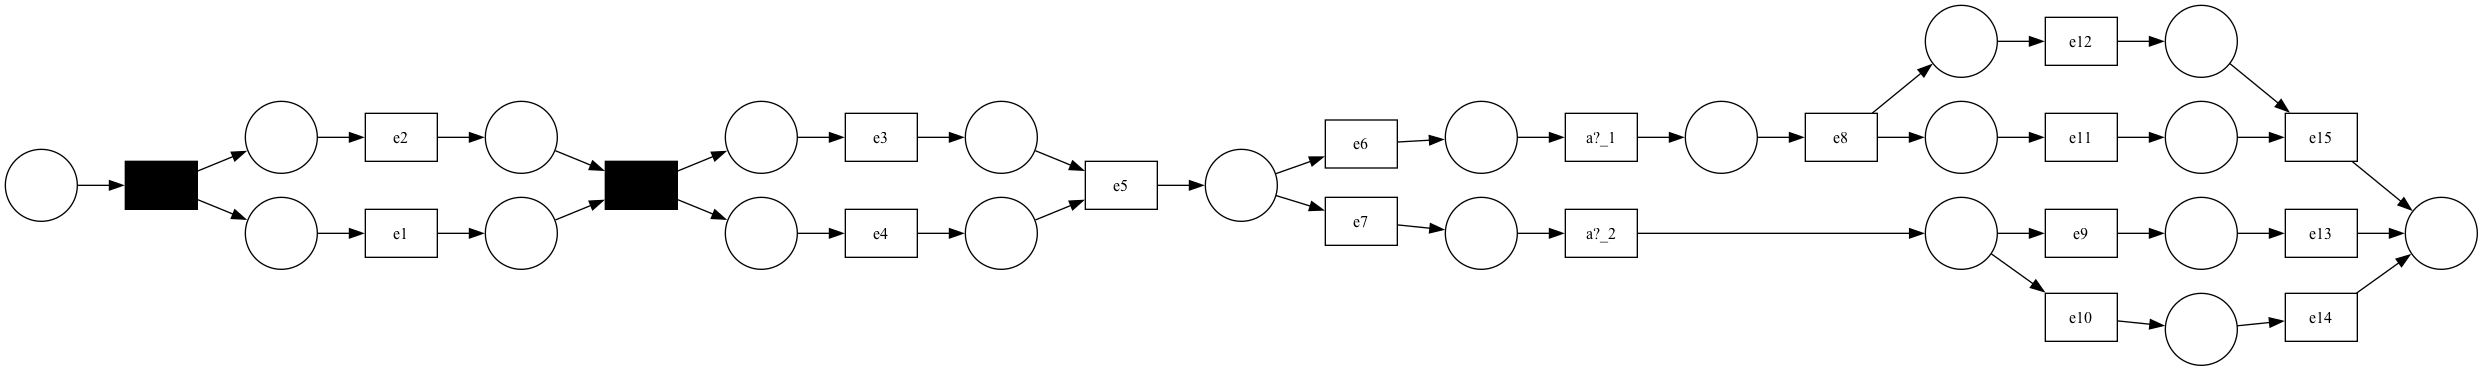

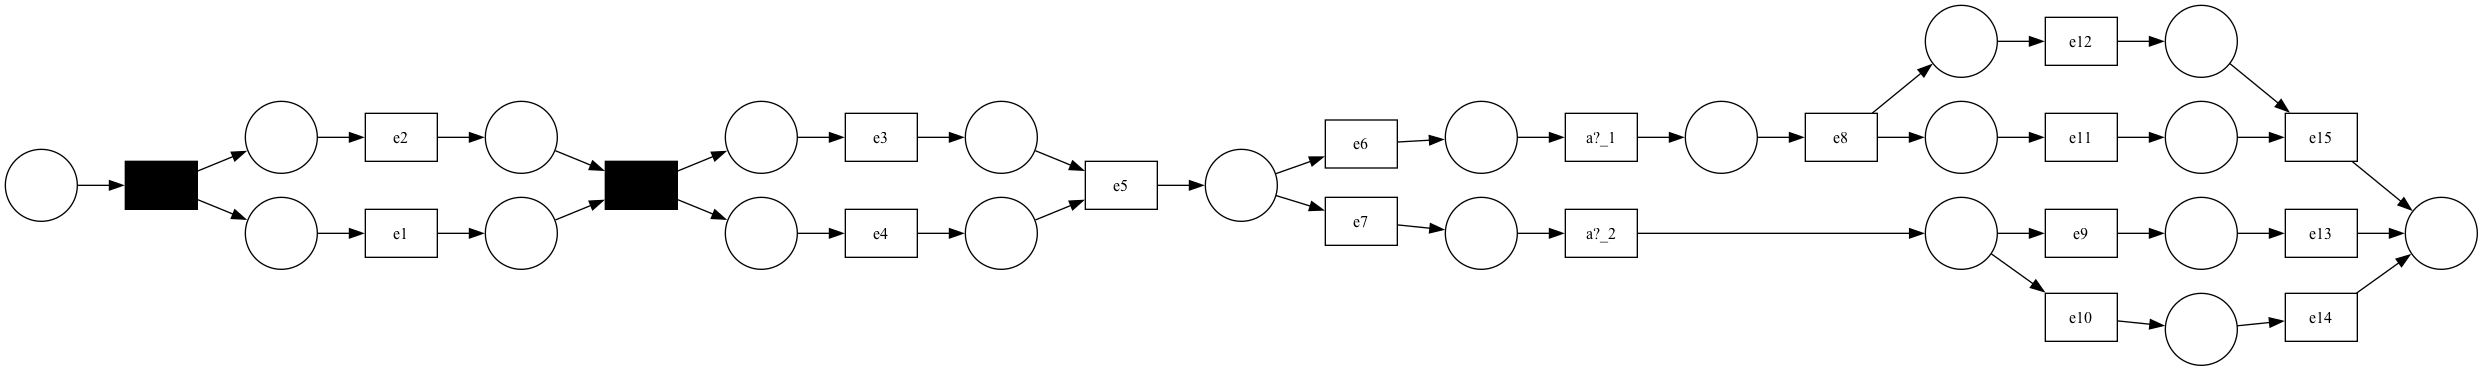

ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv


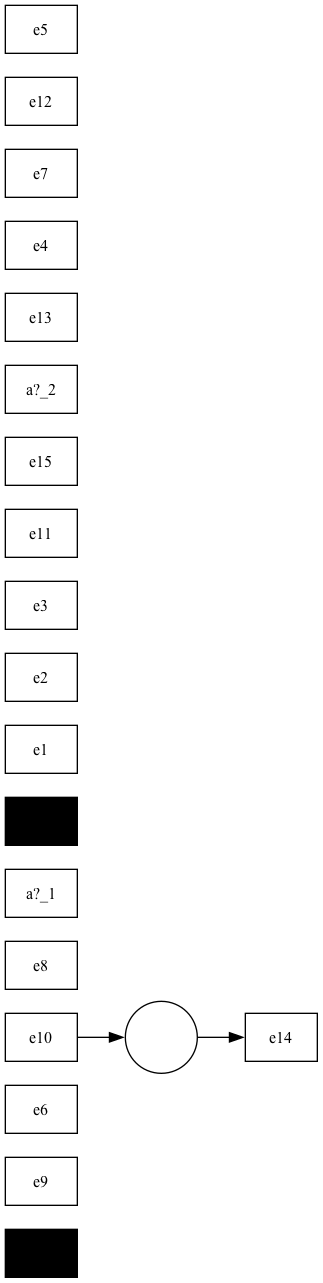

next


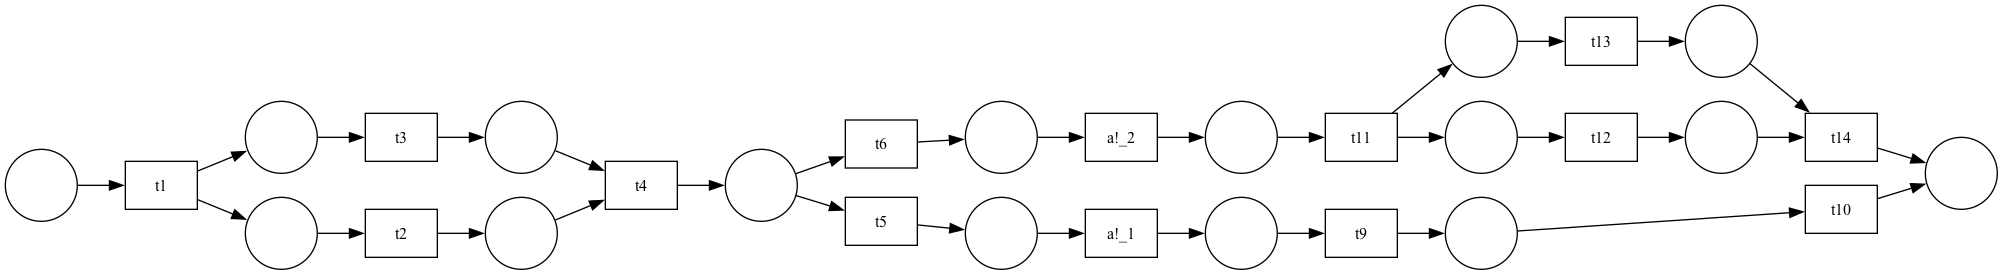

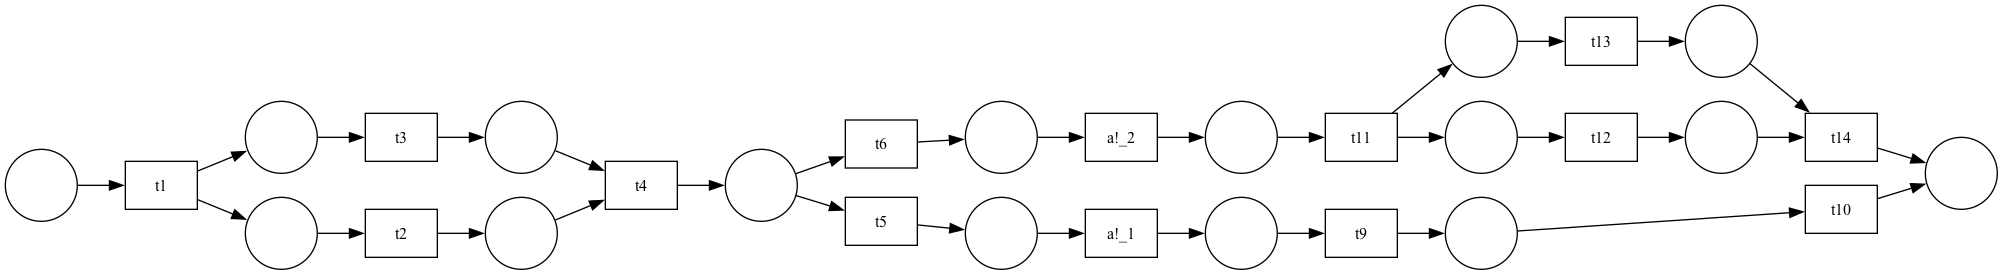

ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv
ifewuv


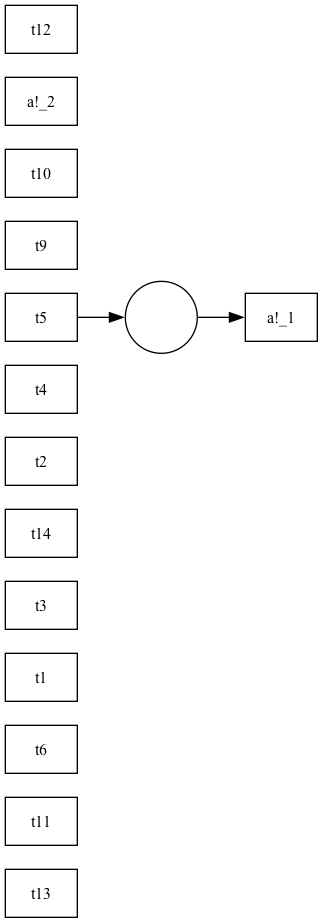

next


In [84]:
from copy import deepcopy

for net in list_of_nets:
    pnet, start, end = net
    pnet = deepcopy(pnet)
    pm4py.view_petri_net(pnet, start, end, format="png")

    #for transition in pnet.transitions.copy():
    #    remove_local_transition(pnet, transition)

    #for transition in pnet.transitions.copy():
    #    remove_transition(pnet, transition)
    pm4py.view_petri_net(pnet, start, end, format="png")

    for place in pnet.places.copy():
        #remove_place(pnet, place)
        if(place_merge(pnet, place)):
            print("ifewuv")
     
    pm4py.view_petri_net(pnet, start, end, format="png")
    print("next")